In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm
from itertools import product
import matplotlib.colors as mcolors
import plotly.express as px

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:

#plt.ion()

In [3]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

seeds = [1337, 3827, 4873, 9999]

hypers = {
	'cma':['popsize','seed','sigma'],
	'pso':['popsize', 'w','seed', 'c1', 'c2'],
	'bo-ucb':['seed','kappa'],
	'bo-ei': ['seed','xi'],
	'bo-poi': ['seed','xi']
}

#goMethods = list(hypers.keys())
goMethods = ['pso', 'cma', 'bo']
print(goMethods)

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations
['pso', 'cma', 'bo']


In [4]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

globalOptimals = xtimeDB.groupby(['progname', 'probsize'])['xtime'].min().reset_index()

print(globalOptimals)

numthreads = 56 if MACHINE in 'ruby' else 80
globalBaselines = xtimeDB.loc[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
										& (xtimeDB['OMP_PROC_BIND'] == 'close')
										& (xtimeDB['OMP_PLACES'] == 'cores')
										& (xtimeDB['OMP_SCHEDULE'] == 'static'),['progname', 'probsize', 'xtime']]

probsizeMap = {'smlprob': 'Small Problem', 'medprob': 'Medium Problem', 'lrgprob': 'Large Problem'}
prognameMap = {'bt_nas': 'BT', 'ft_nas': 'FT', 'hpcg': 'HPCG', 'lulesh':'Lulesh'}

       progname probsize       xtime
0        bt_nas  lrgprob  745.260000
1        bt_nas  medprob   31.943333
2        bt_nas  smlprob    7.383333
3   cfd_rodinia  lrgprob    9.222637
4   cfd_rodinia  medprob    4.186460
5   cfd_rodinia  smlprob    1.578907
6        cg_nas  lrgprob  176.373333
7        cg_nas  medprob    4.796667
8        cg_nas  smlprob    1.143333
9        ft_nas  lrgprob  138.460000
10       ft_nas  medprob    3.903333
11       ft_nas  smlprob    0.940000
12         hpcg  lrgprob   65.220033
13         hpcg  medprob   17.178033
14         hpcg  smlprob    1.949250
15       lulesh  lrgprob   18.396099
16       lulesh  medprob    9.995197
17       lulesh  smlprob    4.854440


In [5]:
overallDF = pd.DataFrame()
tojoin = []
for progname in prognames:
	if progname == 'cg_nas' or progname == 'cfd_rodinia':
		continue
	for method in goMethods:
		# read the pre-processed dataframes
		filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data-rawXtimes.csv'
		fullDF = pd.read_csv(filename)
		tojoin += [fullDF]

overallDF = pd.concat(tojoin, ignore_index=True, sort=True)
overallDF = overallDF.drop(['optimXtime', 'kappa_decay', 'kappa_decay_delay'], axis=1)

print(overallDF.columns)
overallDF.loc[overallDF['method'] == 'bo', 'method'] = overallDF[overallDF['method'] == 'bo'].apply(lambda x: x['method']+'-'+x['utilFnct'], axis=1)
overallDF = overallDF.drop(['utilFnct'], axis=1)

for col in overallDF:
	if col == 'xtime' or col == 'globalSample' or col == 'optimXtime':
		continue
	print(col, overallDF[col].unique())

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize', 'progname', 'seed', 'sigma', 'utilFnct', 'w', 'xi', 'xtime'], dtype='object')
c1 [0.1  0.45 0.8  1.15 1.5   nan]
c2 [0.1  0.45 0.8  1.15 1.5   nan]
kappa [ nan   2.   8.  15.  22.  29.  36.  42.  49.  56.  63.  70.  77.  83.
  90.  97. 104. 111. 118. 124. 131. 138. 145. 152. 159. 165. 172. 179.
 186. 193. 200.]
method ['pso' 'cma' 'bo-ei' 'bo-ucb' 'bo-poi']
popsize [18.  3. 21.  6. 24.  9. 27. 12. 30. 15. nan]
probsize ['smlprob' 'medprob' 'lrgprob']
progname ['bt_nas' 'ft_nas' 'hpcg' 'lulesh']
seed [1337 3827 9999 4873]
sigma [   nan  1.     4.222  7.444 10.667 13.889 17.111 20.333 23.556 26.778
 30.   ]
w [0.1   0.325 0.55  0.775 1.      nan]
xi [  nan 0.    0.357 0.714 1.071 1.429 1.786 2.143 2.5   2.857 3.214 3.571
 3.929 4.286 4.643 5.   ]


In [6]:
print(overallDF.columns)
print(overallDF.shape)

gomethods = list(hypers.keys())
print(gomethods)

Index(['c1', 'c2', 'globalSample', 'kappa', 'method', 'popsize', 'probsize', 'progname', 'seed', 'sigma', 'w', 'xi', 'xtime'], dtype='object')
(20304000, 13)
['cma', 'pso', 'bo-ucb', 'bo-ei', 'bo-poi']


In [7]:
def tupleizeCols(df, cols):
	newColName = f'({",".join([str(col) for col in cols])})'
	df[newColName] = pd.Categorical(list(zip(*[df[col] for col in cols])))
	#df['code'] = df[newColName].cat.codes
	df = df.drop(cols, axis=1)
	return df, newColName

def fix_fig(fig, labels):
	fig.for_each_xaxis(lambda x: x.update(title = ''))
	fig.add_annotation(x=0.5,y=-0.2,
              text=labels['maxSpeedup'],
               xref="paper", yref="paper")
	fig.for_each_yaxis(lambda y: y.update(title = ''))
	fig.add_annotation(x=-0.05,y=0.5, 
              text=labels['firstSample'], textangle=-90,
               xref="paper", yref="paper")
	fig.show()
	return

In [52]:
# now let's take the top 10% of configurations 
# the criteria for selecting the top 10% is their euclidean distance
# of: (((300stepMaxSpeedup - optimalSpeedup)/optimalSpeedup)^2 + ((earliestTimestep-0)/299)^2)^(1/2)
# 

colormap = dict(zip(seeds, ['red', 'orange', 'green', 'blue']))

def plotPercOptimal(overallDF):
	# for each progname, probsize, method combo
	# let's make the plots
	reachedOptim = pd.DataFrame()

	for progname in prognames:
		for method in gomethods:
			newColName = ''

			for probsize in probsizes:
				df = overallDF[(overallDF.progname == progname) & (overallDF.probsize == probsize) & (overallDF.method == method)]
				#df = overallDF[(overallDF.progname == progname) & (overallDF.method == method)]
				cols = hypers[method]
				colsToKeep = cols+['globalSample', 'xtime']
				df = df[colsToKeep]
				df = df.sort_values(by=cols+['globalSample'], ignore_index=True)

				# drop all the first samples, as they're random
				df = df[df['globalSample'] != 0.0 ]

				df['cummin'] = df.groupby(cols)['xtime'].transform('cummin')
				df = df.set_index(cols)
				baselineXtime = globalBaselines[(globalBaselines.progname == progname) & (globalBaselines.probsize == probsize)]['xtime'].iat[0]
				optimalXtime = globalOptimals[(globalOptimals.progname == progname) & (globalOptimals.probsize == probsize)]['xtime'].iat[0]
				optimalXtime = baselineXtime/optimalXtime
				df['baselineXtime'] = baselineXtime/df['cummin']

				#print('optimalXtime')
				#print(optimalXtime)

				earliestSamples = pd.DataFrame(index=df.index.copy())
				earliestSamples = earliestSamples[~earliestSamples.index.duplicated(keep='first')]
				earliestSamples['firstSample'] = 300
				earliestSamples['maxSpeedup'] = 0
				earliestSamples['optimalSpeedup'] = optimalXtime

				# now for each index, find the earliest globalSample that is greater than 1.0
				#toplot['earliestSamp'] = df[df['baselineXtime'] > 1.0, 'globalSample'].min()
				firstSamp = df.loc[df.baselineXtime > 1.0].groupby(level=list(range(len(cols))))['globalSample'].min()
				maxSpeed = df.loc[df.globalSample == 299.0].groupby(level=list(range(len(cols))))['baselineXtime'].max()

				#print('early earliestSamples')
				#print(earliestSamples.head(20))

				earliestSamples['firstSample'].update(firstSamp)
				earliestSamples['maxSpeedup'].update(maxSpeed)
				#earliestSamples['optimalSpeedup'].update(optimalXtime)

				earliestSamples = earliestSamples.reset_index()
				# now let's make the distance metric column
				#earliestSamples['score'] = (((earliestSamples['maxSpeedup'] - optimalXtime)/optimalXtime)**2 + (earliestSamples['firstSample']/299)**2)**(1/2)
				earliestSamples['score'] = earliestSamples['maxSpeedup']*0.5  + 0.5*(1/earliestSamples['firstSample'])

				#print('later earliestSamples')
				#print(earliestSamples.head(20))
				earliestSamples['reachesOptimal'] = (earliestSamples['optimalSpeedup'] == earliestSamples['maxSpeedup']).apply(lambda x: 1 if x else 0)

				numReachedOptimal = earliestSamples.groupby(['seed'])['reachesOptimal'].sum().reset_index(name='numReachedOptimal')
				numTotal = earliestSamples.groupby(['seed'])['reachesOptimal'].count().reset_index(name='numTotal')

				numReachedOptimal = numReachedOptimal.set_index(['seed'])
				numTotal = numTotal.set_index(['seed'])

				#print('numReachedOptimal')
				#print(numReachedOptimal)
				#print('numTotal')
				#print(numTotal)

				percReachedOptimal = pd.DataFrame()
				percReachedOptimal['percOptim'] = 100 * numReachedOptimal['numReachedOptimal'] / numTotal['numTotal']

				#print('percReachedOptimal')
				#print(percReachedOptimal)
				
				percReachedOptimal = percReachedOptimal.reset_index()
				percReachedOptimal['method'] = method
				percReachedOptimal['probsize'] = probsize
				percReachedOptimal['progname'] = progname 

				reachedOptim = pd.concat([reachedOptim, percReachedOptimal], ignore_index=True)

			# now take the top 10s and plot them
			#print(f'{progname} {method} \n')#, top10s)
			#print('reachedOptim')
			#print(reachedOptim)
			#continue

	# we're gonna make a bar plot where the bars go from left to right
	# then we're gonna add annotations that show what each is
	def makeSubPlot(*args, **kwargs):
		data = kwargs.pop('data')

		#data = data.drop(['firstSample', 'maxSpeedup'], axis=1)
		#data.loc[:,'score'] = data.score.round(5)
		#ax = sns.scatterplot(data, x=0, y='score')

		data = data.drop(['probsize', 'progname'], axis=1)
		data.seed = data.seed.astype('category')

		#print('data\n', data.dtypes, '\n', data.pivot(index=newColName, columns='seed', values='score'))

		#data.set_index(newColName).plot(kind='barh', y='score', stacked=True, ax=plt.gca())
		#data.set_index(newColName).plot(kind='barh', y='score', stacked=True, alpha=0.25, ax=plt.gca())
		##data.set_index(newColName).plot(kind='barh', y='score', stacked=True, alpha=0.25, ax=plt.gca())

		#data.pivot(index=newColName, columns='seed', values='score').plot(kind='barh', stacked=True, ax=plt.gca())

		# this works for stacked
		#data.pivot(index=newColName, columns='seed', values='score').plot(kind='barh', stacked=False, ax=plt.gca())

		sns.heatmap(data.pivot(index='method', columns='seed', values='percOptim'), vmin=0, vmax=100, annot=True, fmt='.3g')

		#ax = plt.gca()
		#ax.set_yticks(list(range(len(yelems))))
		#ax.set_yticklabels(yelems)
		#ax.set_ylabel(newColName)
		#ax.set_xlabel('Score')
		return

	print(reachedOptim)

	g = sns.FacetGrid(reachedOptim, col='probsize', row='progname', sharex=False, sharey=False, height=6, aspect=1.2)
	g.map_dataframe(makeSubPlot)

	g.fig.subplots_adjust(top=0.95)
	g.fig.suptitle(f'Percent of hyperparameters finding optimal by the 300th step')
		
	#lgnd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title='seed', reverse=True)

	#ax = plt.gca()
	#handles, labels = ax.get_legend_handles_labels()
	#unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
	#unique = sorted(unique, key=lambda x: x[1], reverse=True)
	#ax.legend(*zip(*unique), bbox_to_anchor=(1.05, 1), loc=2, title='seed', reverse=True)


	plt.show()

			
	return

     seed   percOptim  method probsize progname
0    1337    1.000000     cma  smlprob   bt_nas
1    3827   10.000000     cma  smlprob   bt_nas
2    4873   11.000000     cma  smlprob   bt_nas
3    9999    8.000000     cma  smlprob   bt_nas
4    1337   34.000000     cma  medprob   bt_nas
5    3827    9.000000     cma  medprob   bt_nas
6    4873   19.000000     cma  medprob   bt_nas
7    9999   24.000000     cma  medprob   bt_nas
8    1337   11.000000     cma  lrgprob   bt_nas
9    3827   10.000000     cma  lrgprob   bt_nas
10   4873   18.000000     cma  lrgprob   bt_nas
11   9999    1.000000     cma  lrgprob   bt_nas
12   1337   18.720000     pso  smlprob   bt_nas
13   3827   26.320000     pso  smlprob   bt_nas
14   4873   28.160000     pso  smlprob   bt_nas
15   9999   11.040000     pso  smlprob   bt_nas
16   1337    6.160000     pso  medprob   bt_nas
17   3827   15.920000     pso  medprob   bt_nas
18   4873   14.960000     pso  medprob   bt_nas
19   9999    7.200000     pso  medprob  

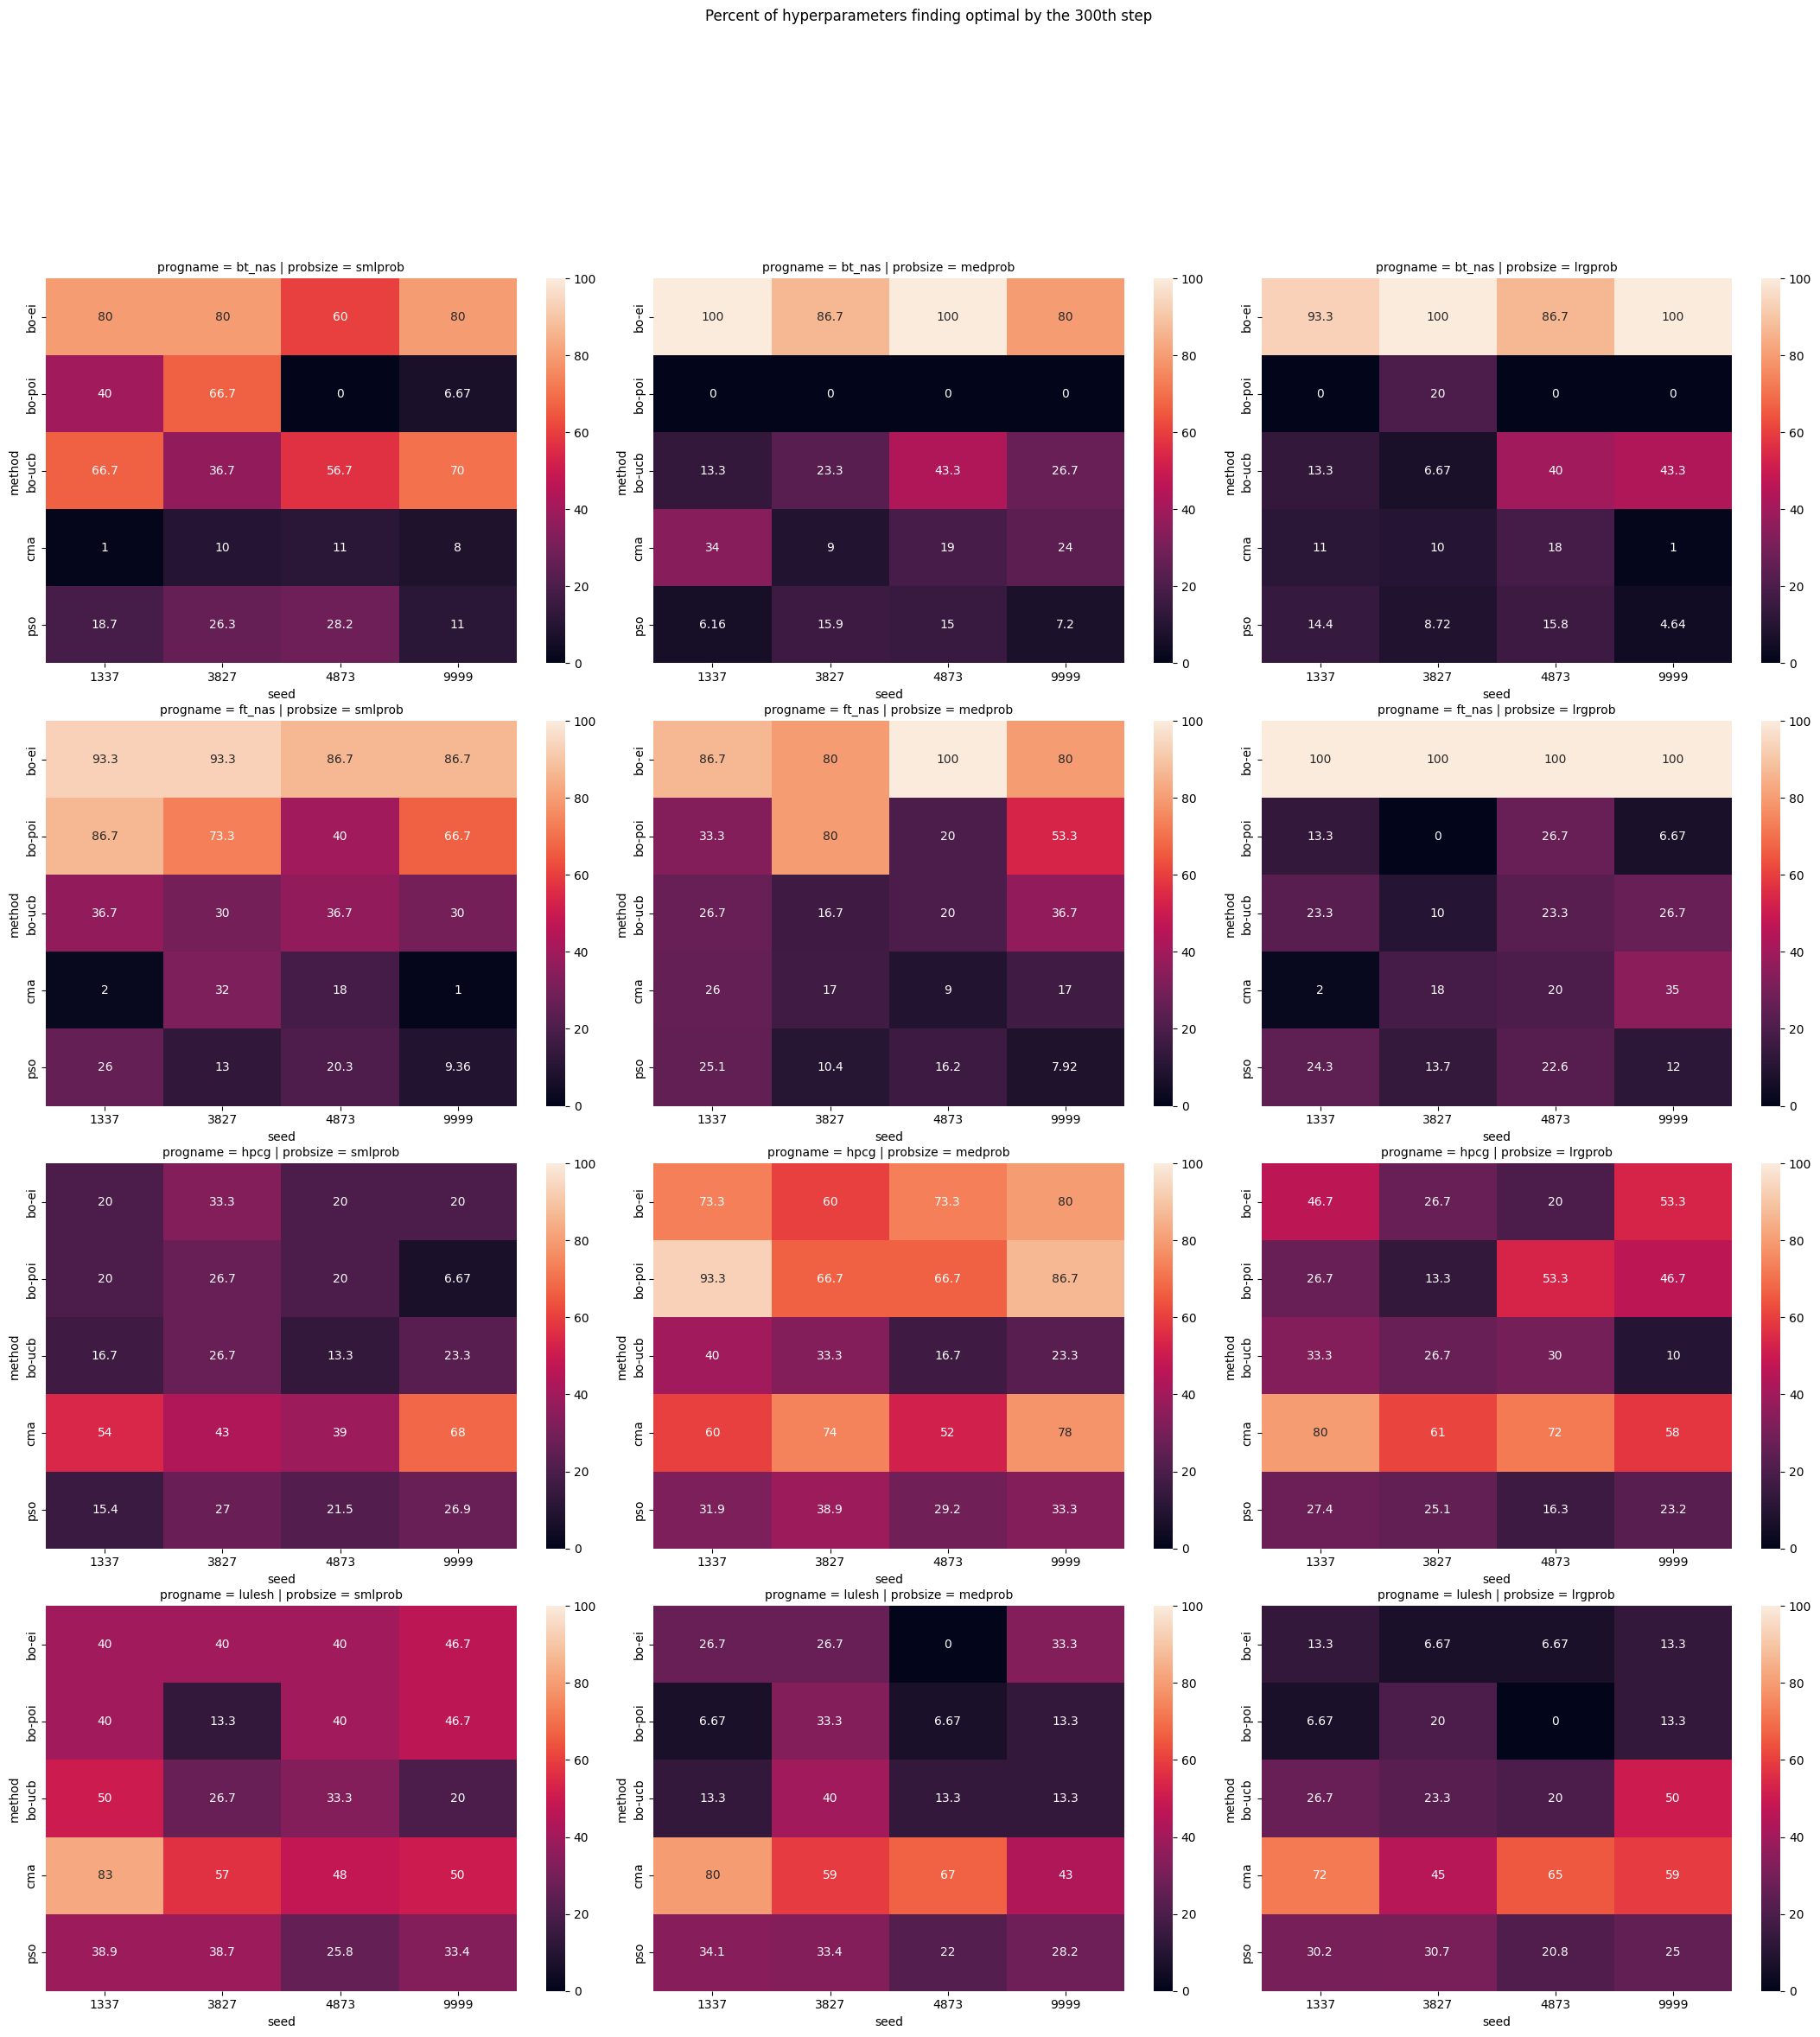

In [53]:
plotPercOptimal(overallDF)